In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# filter df by imported filters
def check_filters(df, filters):
    """
    Check filters against thresholds for each row in a DataFrame.
    Returns a DataFrame with an additional column 'unmet_conditions' listing unmet conditions for each row.
    """
    def check_row(row):
        unmet_conditions = []
        for label, conditions in filters.items():
            # special conditions for interface amino acid counts
            if label in ['Average_InterfaceAAs', '1_InterfaceAAs', '2_InterfaceAAs', '3_InterfaceAAs', '4_InterfaceAAs', '5_InterfaceAAs']:
                aa_dict = row.get(label)
                if not isinstance(aa_dict, dict):
                    continue
                #print(label)
                for aa, aa_conditions in conditions.items():
                    value = aa_dict.get(aa) if aa_dict else None
                    if value is None or aa_conditions.get("threshold") is None:
                        continue
                    if aa_conditions.get("higher"):
                        if value < aa_conditions["threshold"]:
                            unmet_conditions.append(f"{label}_{aa}")
                            return False
                    else:
                        if value > aa_conditions["threshold"]:
                            unmet_conditions.append(f"{label}_{aa}")
                            return False
            else:
                value = row.get(label)
                if value is None or conditions.get("threshold") is None:
                    continue
                #print(label)
                if conditions.get("higher"):
                    if value < conditions["threshold"]:
                        unmet_conditions.append(label)
                        return False
                else:
                    if value > conditions["threshold"]:
                        unmet_conditions.append(label)
                        return False
        return True

    filter_df = df.copy()
    filter_df['unmet_conditions'] = filter_df.apply(check_row, axis=1)
    filter_df = filter_df[filter_df['unmet_conditions']]
    print(f"After applying prediction quality filters, {len(filter_df)} designs remain.")
    print('success rate:', len(filter_df) / len(df))
    return filter_df

In [9]:
# generate filtered designs
import json

filter_path = "/home/lwang/models/BindCraft/BindCraft_fork/extra_settings/no_PB_filters.json"
with open(filter_path, "r") as f:
    filter_json = json.load(f)

def filter(file, filter_json):
    df = pd.read_csv(file)
    filtered_ = check_filters(df, filter_json)
    filtered_.to_csv(file.replace('.csv', '_filtered.csv'))

design_file = '/home/lwang/models/BindCraft/BindCraft_fork/5mj4_BC_scaffold/final_design_stats_merged.csv'
filter(design_file, filter_json)

After applying prediction quality filters, 21 designs remain.
success rate: 0.002061653249558217


In [12]:
## Customize filters
import pandas as pd

pred_quality_filters = {
    'Average_pLDDT': ('more than', 0.65),
    'Average_i_pTM': ('more than', 0.5),
    'Average_pTM': ('more than', 0.55),
    'Average_i_pAE': ('less than', 0.5),
    'Average_Binder_pLDDT': ('more than', 0.65)
}

Rosetta_filters = {
    'Average_ShapeComplementarity': ('more than', 0.55),
    'InterfaceResidues_num': ('more than', 6),
    'Average_n_InterfaceUnsatHbonds': ('less than', 6),
    'Average_Binder_Energy_Score': ('less than', 0),
    'Average_dG': ('less than', 0),
    'Average_dSASA': ('more than', 1), 
    'Average_n_InterfaceResidues': ('more than', 7), # Default 7
    'Average_n_InterfaceHbonds' : ('more than', 3), # Default 3
    'Average_Binder_Loop%': ('less than', 90), # Default 90
    'Average_Hotspot_RMSD': ('less than', 10), # Default 6
    'Average_Binder_RMSD': ('less than', 5) # Default 3.5
}

def count_interface_residues(df):
    df['InterfaceResidues_num'] = df['InterfaceResidues'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
    return df

def apply_filters(df, use_pred_filters=True, use_rosetta_filters=True):
    df = count_interface_residues(df)
    ori_num = len(df)

    if use_pred_filters:
        for filter_name, (condition, threshold) in pred_quality_filters.items():
            if filter_name not in df.columns:
                continue
            if condition == 'more than':
                df = df[df[filter_name] > threshold]
            elif condition == 'less than':
                df = df[df[filter_name] < threshold]

    if use_rosetta_filters:
        for filter_name, (condition, threshold) in Rosetta_filters.items():
            if filter_name not in df.columns:
                continue
            if condition == 'more than':
                df = df[df[filter_name] > threshold]
            elif condition == 'less than':
                df = df[df[filter_name] < threshold]

    print(f"After applying prediction quality filters, {len(df)} designs remain.")
    print('success rate:', len(df) / ori_num)
    return df

In [7]:
# write XMPNN config

import yaml

class FlowStyleList(list):
    pass
def flow_style_list_representer(dumper, data):
    return dumper.represent_sequence('tag:yaml.org,2002:seq', data, flow_style=True)
yaml.add_representer(FlowStyleList, flow_style_list_representer)

def write_mpnn_config(yaml_dir, pdb_fpath, binder_chain, fix_pos: list, num_seq_per_target=50, batch_size=4):
    config = {
        "gpus": "Multiple",
        "fixed_positions": [FlowStyleList(fix_pos)],
        "chains_to_design": binder_chain,
        "omit_aas": ['C'],  # Use a list for omit_aas
        # model params
        "homoligomer": 1,
        "num_seq_per_target": num_seq_per_target,
        "sampling_temp": 0.1,
        "initial_seed": 0,
        "batch_size": batch_size,
        "mode": "design"
    }
    fname = os.path.basename(pdb_fpath)
    yaml_path = os.path.join(yaml_dir, f"{fname.replace('.pdb', '.yaml')}")
    with open(yaml_path, "w") as f:
        yaml.dump(config, f, default_flow_style=False)
    print(f"YAML file written to: {yaml_path}")

In [17]:
# apply customize filters
parse_df = pd.read_csv("/home/lwang/models/BindCraft/BindCraft_fork/5mj4_dplm_scaffold/final_design_stats_merged.csv")
print(parse_df.shape)
filter_df = apply_filters(parse_df, use_pred_filters=True, use_rosetta_filters=True)
print(filter_df.shape)

show_cols = ['Design', 'Length', 'Sequence'] + list(pred_quality_filters.keys()) + list(Rosetta_filters.keys())
display(filter_df[show_cols])

# write XMPNN config
'''binder_chain = "B"
target_chain = "A"
yaml_dir = "/home/lwang/models/BindCraft/BindCraft_fork/5mj4_dplm_scaffold/XMPNN_config"
for index, row in filter_df.iterrows():
    pdb_fpath = row['Design'] + '.pdb'
    fix_pos = [pos for pos in row['InterfaceResidues'].split(',')]
    write_mpnn_config(yaml_dir, pdb_fpath, binder_chain, fix_pos, num_seq_per_target=100, batch_size=16)'''

(2425, 232)
After applying prediction quality filters, 4 designs remain.
success rate: 0.0016494845360824743
(4, 233)


,Design,Length,Sequence,Average_pLDDT,Average_i_pTM,Average_pTM,Average_i_pAE,Average_Binder_pLDDT,Average_ShapeComplementarity,InterfaceResidues_num,Average_n_InterfaceUnsatHbonds,Average_Binder_Energy_Score,Average_dG,Average_dSASA,Average_n_InterfaceResidues,Average_n_InterfaceHbonds,Average_Binder_Loop%,Average_Hotspot_RMSD,Average_Binder_RMSD
68,sample_7937_relaxed,66,TQKEIAQIQAVIAGIQKYIYTMFGTILQMIADKVSVELAVEFLKQI...,0.74,0.58,0.79,0.40,0.86,0.75,66,0.0,-129.09,-56.41,1781.37,66,4,9.09,9.64,2.17
1593,traj8_sample_17004_relaxed,75,NKQKEIAQIQAVIAGIQKYIYTMGLNLVSVTQAMENISKDLILIAE...,0.68,0.55,0.76,0.47,0.83,0.65,75,5.0,-153.72,-50.82,1899.52,75,5,16.00,6.47,1.92
1852,traj8_sample_12869_relaxed,70,TLQKEIAQIQAVIAGIQKYIYTMLEEAIGDIRSGNSSDAVETLDQI...,0.80,0.61,0.79,0.38,0.87,0.76,70,1.0,-142.81,-52.72,1632.87,70,5,7.14,8.48,0.59
1910,traj8_sample_22168_relaxed,72,VSQKEIAQIQAVIAGIQKYIYTMGVKNNELISTVRELATLKDPTVE...,0.78,0.61,0.78,0.41,0.87,0.61,72,2.0,-155.42,-55.50,2058.24,72,5,19.44,7.33,0.66


'binder_chain = "B"\ntarget_chain = "A"\nyaml_dir = "/home/lwang/models/BindCraft/BindCraft_fork/5mj4_dplm_scaffold/XMPNN_config"\nfor index, row in filter_df.iterrows():\n    pdb_fpath = row[\'Design\'] + \'.pdb\'\n    fix_pos = [pos for pos in row[\'InterfaceResidues\'].split(\',\')]\n    write_mpnn_config(yaml_dir, pdb_fpath, binder_chain, fix_pos, num_seq_per_target=100, batch_size=16)'

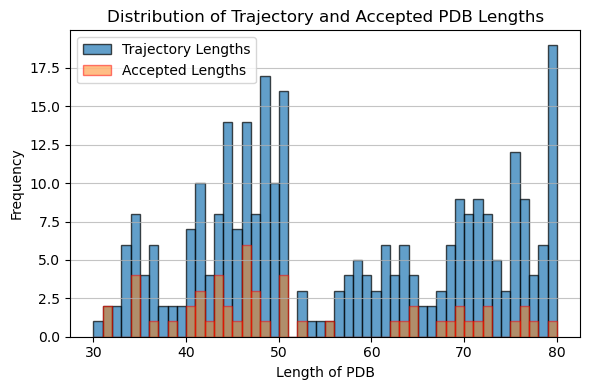

In [24]:
# plot length distribution of trajectory and accepted designs
def plot_length(file, filtered_file, filter_json, seedID=1):
    traj_df = pd.read_csv(file)
    if not filtered_file:
        acc_df = check_filters(traj_df, filter_json)
    else:
        acc_df = pd.read_csv(filtered_file)
    #traj_df['traj_batch'] = traj_df['Design'].apply(lambda x: x.split('_')[seedID])
    #acc_df['traj_batch'] = acc_df['Design'].apply(lambda x: x.split('_')[seedID])
    traj_df['traj_batch'] = traj_df['Design'].apply(lambda x: "_".join(x.split('_')[:seedID]))
    acc_df['traj_batch'] = acc_df['Design'].apply(lambda x: "_".join(x.split('_')[:seedID]))
    traj_df = traj_df.drop_duplicates(subset=['traj_batch', 'Length'])
    acc_df = acc_df.drop_duplicates(subset=['traj_batch', 'Length'])
    traj_length = traj_df['Length'].tolist()
    acc_length = acc_df['Length'].tolist()

    plt.figure(figsize=(6, 4))
    # Define the bin range from 30 to 80 with a step of 1
    bins = np.arange(30, 81, 1)

    plt.hist(traj_length, bins=bins, edgecolor='black', alpha=0.7, label='Trajectory Lengths')
    plt.hist(acc_length, bins=bins, edgecolor='red', alpha=0.5, label='Accepted Lengths')
    plt.title('Distribution of Trajectory and Accepted PDB Lengths')
    plt.xlabel('Length of PDB')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.legend()
    plt.tight_layout()
    plt.show()

file = '/home/lwang/models/BindCraft/BindCraft_fork/IL23_RF_XMPNN/IL23_RF_XMPNN_selected.csv'
plot_length(file, IL23_RF_XMPNN_file, filter_json, seedID=2) # may need to adjust seedID for dropping duplicates

(1654, 237)


/tmp/ipykernel_59239/2520582241.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


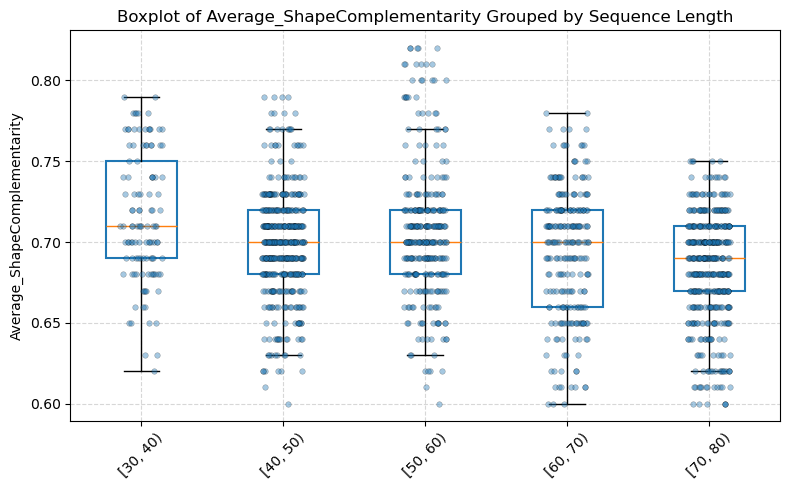

(1654, 237)


/tmp/ipykernel_59239/2520582241.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


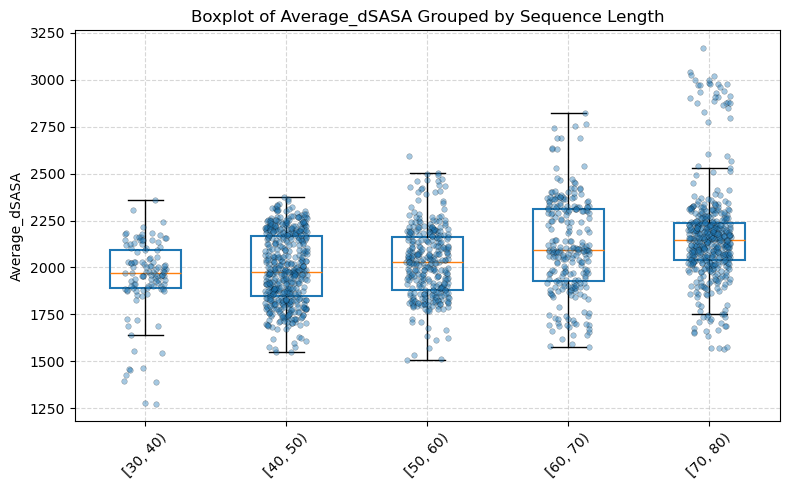

(1654, 237)


/tmp/ipykernel_59239/2520582241.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


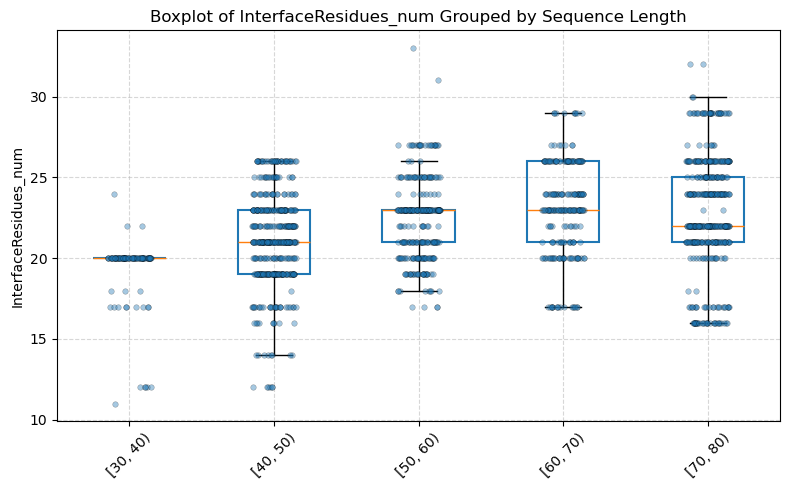

(1654, 237)


/tmp/ipykernel_59239/2520582241.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


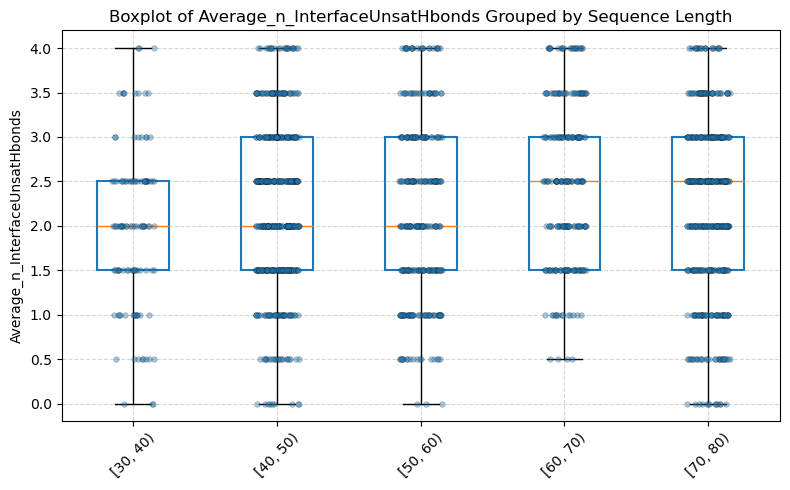

In [ ]:
# plot distribution of design properties by length
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pred_quality_filters = {
    'Average_pLDDT': ('more than', 0.8),
    'Average_i_pTM': ('more than', 0.5),
    'Average_pTM': ('more than', 0.55),
    'Average_i_pAE': ('less than', 0.35),
}

Rosetta_filters = {
    'Average_ShapeComplementarity': ('more than', 0.5),
    'Average_dSASA': ('more than', 1.0),
    'InterfaceResidues_num': ('more than', 7),
    #'Average_Interface_Hydrophobicity': ('less than', 0.37),
    'Average_n_InterfaceUnsatHbonds': ('less than', 3),
}

def plot_boxplot_by_length(design_df, target_metric, cutoff=0.3):
    print(design_df.shape)
    data_to_plot = [design_df.loc[design_df['len_bin'] == bin, target_metric].dropna().values
                    for bin in design_df['len_bin'].cat.categories]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    box = ax.boxplot(
        data_to_plot,
        labels=rigidity_labels,
        patch_artist=True,
        showfliers=False  # Hide outliers for clarity
    )
    
    #ax.axhline(y=cutoff, color='r', linestyle='--', label='Cutoff Line')    

    # Make box interiors transparent with colored edges
    for patch in box['boxes']:
        patch.set(facecolor='none', edgecolor='C0', linewidth=1.5)

    # Overlay jittered scatter
    for i, y in enumerate(data_to_plot, 1):
        x_jitter = np.random.uniform(-0.15, 0.15, size=len(y))
        ax.scatter(np.full_like(y, i) + x_jitter, y,
                alpha=0.4, color='C0', s=16, edgecolors='k', linewidths=0.3, zorder=3)

    # Final styling
    ax.set_xticklabels(rigidity_labels, rotation=45)
    ax.set_ylabel(target_metric)
    ax.set_title(f'Boxplot of {target_metric} Grouped by Sequence Length')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


metrics = ['Average_pLDDT', 'Average_i_pTM', 'Average_ShapeComplementarity', 'Average_Binder_Energy_Score']
target_metric = 'Average_i_pAE'

for target_metric,cutoff in Rosetta_filters.items(): # adjust items to plot here
    design_df = pd.read_csv(IL23_BC_PMPNN_file.replace('.csv', '_filtered.csv')) # adjust file to parse here
    design_df['length'] = design_df['Sequence'].apply(len)
    design_df['InterfaceResidues_num'] = design_df['InterfaceResidues'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

    # Define length bins
    length_bins = np.arange(30, 90, 10)
    design_df['len_bin'] = pd.cut(design_df['length'], bins=length_bins, right=False)
    rigidity_labels = [f"[{int(b.left)}, {int(b.right)})" for b in design_df['len_bin'].cat.categories]

    plot_boxplot_by_length(design_df, target_metric, cutoff=cutoff[1])
#plt.savefig(f'/home/lwang/models/BindCraft/IL23/figures/boxplot_{target_metric}_by_length.png', dpi=300)
